# Stock Price Prediction using LSTM

In [9]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import rc
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from pylab import rcParams
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Bidirectional, Dropout
from tensorflow.keras.layers import Activation, Dense, LSTM
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential
import warnings
warnings.filterwarnings('ignore')
rcParams['figure.figsize'] = 18, 12

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
%matplotlib inline

## Reading Data

In [ ]:
from google.colab import files
files.upload()

In [3]:
stock_df = pd.read_csv('SBI.csv', parse_dates=['Date'])

In [4]:
print(stock_df.shape)
stock_df.head()

(2634, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,227.500000,230.000000,227.500000,229.119995,95.066895,11031470.0
1,2010-01-05,230.800003,231.000000,228.009995,229.205002,95.102180,11613740.0
2,2010-01-06,229.699997,231.500000,228.500000,230.580002,95.672699,14527930.0
3,2010-01-07,230.600006,231.000000,228.110001,229.289993,95.137444,8576510.0
4,2010-01-08,229.399994,230.389999,228.009995,228.604996,94.853218,10453820.0


In [5]:
df = stock_df.drop(['Adj Close', 'Volume'], axis=1, inplace=False)
print(df.shape)
df.head()

(2634, 5)


,Date,Open,High,Low,Close
0,2010-01-04,227.500000,230.000000,227.500000,229.119995
1,2010-01-05,230.800003,231.000000,228.009995,229.205002
2,2010-01-06,229.699997,231.500000,228.500000,230.580002
3,2010-01-07,230.600006,231.000000,228.110001,229.289993
4,2010-01-08,229.399994,230.389999,228.009995,228.604996


In [6]:
df.tail()

,Date,Open,High,Low,Close
2629,2020-08-24,200.0,202.800003,198.600006,201.449997
2630,2020-08-25,204.0,208.449997,202.699997,207.949997
2631,2020-08-26,208.5,210.350006,206.149994,209.850006
2632,2020-08-27,210.5,216.500000,210.500000,215.649994
2633,2020-08-28,217.0,225.899994,216.800003,224.850006


## Visualizing Data

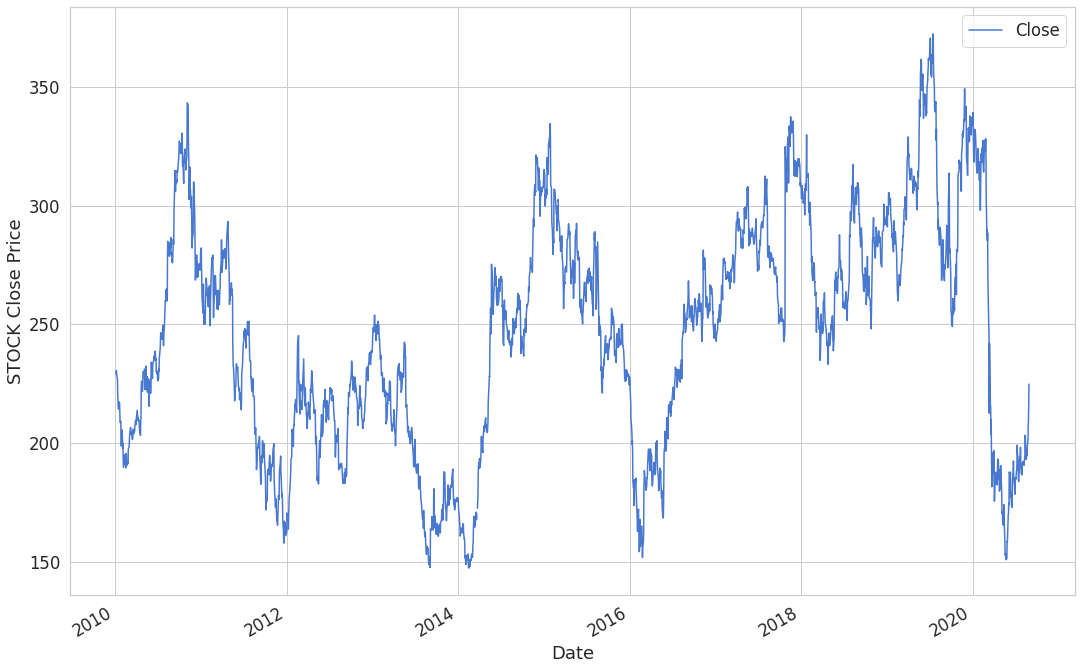

In [10]:
ax = df.plot(x='Date', y='Close');
ax.set_xlabel("Date")
ax.set_ylabel("STOCK Close Price")
plt.show()

## Data Preprocessing

### Splitting Data into Train and Test Dataset based on Date

In [11]:
split_date = pd.datetime(2017,8,20)

train_data = df.loc[df['Date'] <= split_date]
test_data = df.loc[df['Date'] > split_date]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  """Entry point for launching an IPython kernel.


In [12]:
print(train_data.shape)
print(test_data.shape)

(1889, 5)
(745, 5)


In [13]:
training_data = train_data['Close']
testing_data = test_data['Close']

### Data Normalization

In [14]:
scaler = MinMaxScaler(feature_range=(0, 1))

training_data_scaled = scaler.fit_transform(training_data.values.reshape(-1,1))
testing_data_scaled = scaler.transform(testing_data.values.reshape(-1,1))

### Checking for NaN values

In [15]:
print(training_data_scaled.shape)
np.isnan(training_data_scaled).any()

(1889, 1)


True

In [16]:
print(testing_data_scaled.shape)
np.isnan(testing_data_scaled).any()

(745, 1)


True

In [17]:
training_data_scaled = training_data_scaled[~np.isnan(training_data_scaled)]
testing_data_scaled = testing_data_scaled[~np.isnan(testing_data_scaled)]

In [18]:
training_data_scaled = training_data_scaled.reshape(-1, 1)
testing_data_scaled = testing_data_scaled.reshape(-1,1)

In [19]:
print(training_data_scaled.shape)
np.isnan(training_data_scaled).any()

(1882, 1)


False

In [20]:
print(testing_data_scaled.shape)
np.isnan(testing_data_scaled).any()

(744, 1)


False

### Converting Data to Sequences

In [21]:
SEQ_LEN = 100

def data_to_sequences(data, seq_len):
    x_data = []
    y_data = []

    for index in range(len(data) - seq_len):
        x_data.append(data[index: index + seq_len])
        y_data.append(data[index])

    x_data, y_data = np.array(x_data), np.array(y_data)
    x_data = np.reshape(x_data, (x_data.shape[0], x_data.shape[1], 1))

    return x_data, y_data

In [22]:
x_train, y_train = data_to_sequences(training_data_scaled, SEQ_LEN)
x_test, y_test = data_to_sequences(testing_data_scaled, SEQ_LEN)

print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

(1782, 100, 1)
(1782,)
(644, 100, 1)
(644,)


## Model

In [37]:
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN

model = Sequential()

model.add(Bidirectional(CuDNNLSTM(WINDOW_SIZE, return_sequences=True), input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(CuDNNLSTM(WINDOW_SIZE, return_sequences=True)))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(CuDNNLSTM(WINDOW_SIZE, return_sequences=True)))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(CuDNNLSTM(WINDOW_SIZE, return_sequences=False)))
model.add(Dropout(rate=DROPOUT))

model.add(Dense(units=1))
model.add(Activation('tanh'))

### Training Model

In [38]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [39]:
BATCH_SIZE = 32

history = model.fit(x_train, y_train, epochs=45, 
    batch_size=BATCH_SIZE, shuffle=False, validation_split=0.2)

Epoch 1/45
45/45 [==============================] - 9s 211ms/step - loss: 0.0479 - val_loss: 0.1398
Epoch 2/45
45/45 [==============================] - 2s 44ms/step - loss: 0.0399 - val_loss: 0.2726
Epoch 3/45
45/45 [==============================] - 2s 42ms/step - loss: 0.0316 - val_loss: 0.0137
Epoch 4/45
45/45 [==============================] - 2s 43ms/step - loss: 0.0180 - val_loss: 0.0091
Epoch 5/45
45/45 [==============================] - 2s 43ms/step - loss: 0.0047 - val_loss: 0.0020
Epoch 6/45
45/45 [==============================] - 2s 43ms/step - loss: 0.0029 - val_loss: 0.0022
Epoch 7/45
45/45 [==============================] - 2s 43ms/step - loss: 0.0031 - val_loss: 0.0015
Epoch 8/45
45/45 [==============================] - 2s 43ms/step - loss: 0.0029 - val_loss: 0.0018
Epoch 9/45
45/45 [==============================] - 2s 43ms/step - loss: 0.0027 - val_loss: 0.0013
Epoch 10/45
45/45 [==============================] - 2s 43ms/step - loss: 0.0029 - val_loss: 0.0019
Epoch 11

### Evaluating Model

In [40]:
model.evaluate(x_test, y_test)

21/21 [==============================] - 5s 255ms/step - loss: 0.0019


0.0018622081261128187

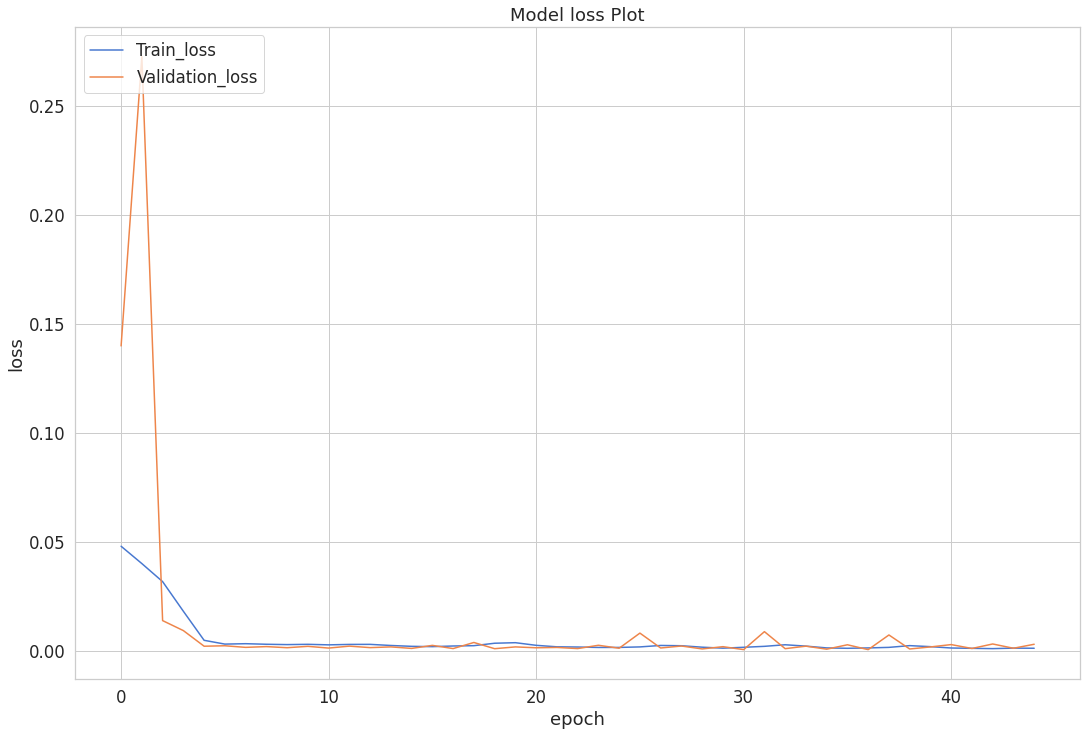

In [41]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss Plot')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train_loss', 'Validation_loss'], loc='upper left')
plt.show()

### Model Predictions

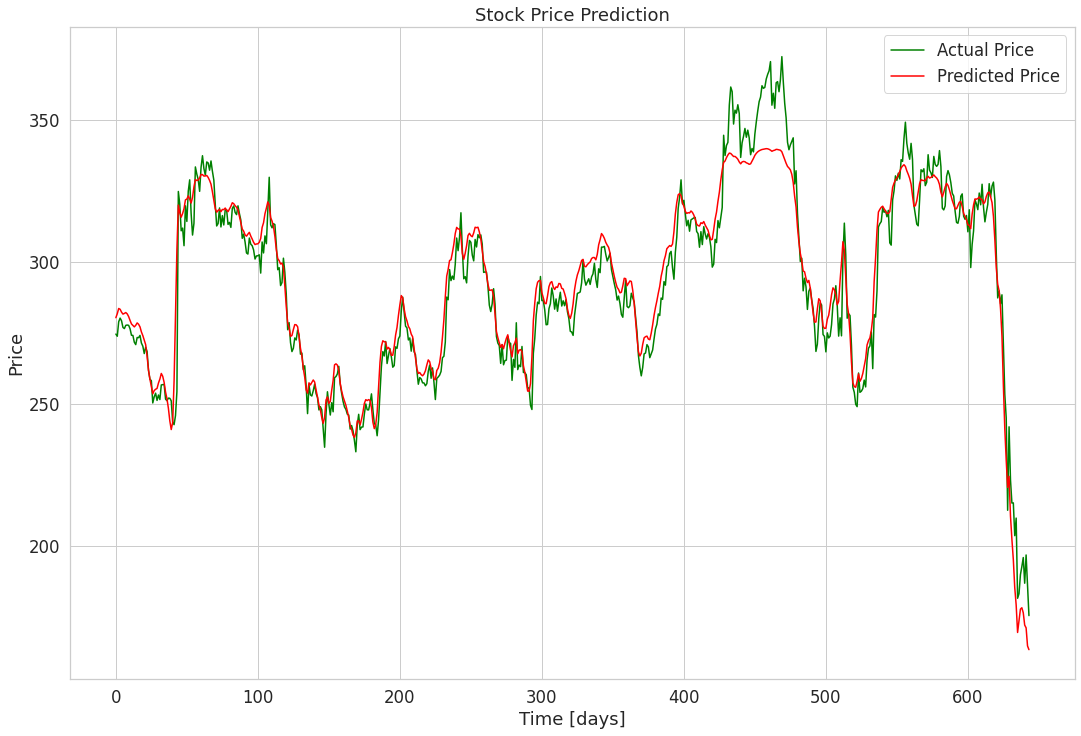

In [42]:
y_hat = model.predict(x_test)

y_test_inverse = scaler.inverse_transform(y_test.reshape(-1,1))
y_hat_inverse = scaler.inverse_transform(y_hat)
 
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('Stock Price Prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show()

## Summary 

- Here we performed stock closing price prediction on SBI stock data using LSTM
- For this problem we have used SBI stock data of last 10 years
- We used Stock data from 04-01-2010 to 20-08-2017 for training and 21-08-2017 to 28-08-2020 for testing
- We got a test loss of 0.001862
- As we can see the predicted stock prices are very close to actual stock prices